In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
from utils import *

In [27]:
def load_all_data(dir, filecnt=54):
    data = [None]*10
    t = np.zeros((10, filecnt), int)
    for p in range(10):
        d = [None]*filecnt
        for i in range(filecnt):
            d[i] = np.load(f"{dir}/{p}/{i+1}.npy")
            t[p,i] = d[i].shape[0]
        data[p] = d
    return data, t

def load_with_config(dir, config):
    config_arr = np.array(pd.read_csv(f"{config}", header=None))
    data, t = load_all_data(dir)
    return data, config

def match_length(d, t:int):
    """
    return (pattern, N, times(t), 2) shape numpy array
    """
    x = np.zeros((len(d), len(d[0]), t, 2), np.float64)
    target_timepoints = np.linspace(0, 1, t)
    for r in range(len(d)):
        for c in range(len(d[r])):
            origin_timepoints = np.linspace(0, 1, d[r][c].shape[0])
            x[r, c, :, 0] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,0])
            x[r, c, :, 1] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,1])
    return x      

def apply_normalize(d):
    for r in range(len(d)):
        for c in range(len(d[r])):
            d[r][c][:,0] = d[r][c][:,0] - d[r][c][0,0]
            d[r][c][:,1] = d[r][c][:,1] - d[r][c][0,1]
    
def plot_data(d):
    plt.figure(figsize=(20,4))
    plt.subplot(2,1,1)
    gca = plt.gca()
    gca.plot(d[:,0])
    plt.subplot(2,1,2)
    gca = plt.gca()
    gca.plot(d[:,1])
    plt.tight_layout()
    plt.show()

def plot_data2(d, save=None, cmap_name="gist_rainbow"):
    fig, axes = plt.subplot_mosaic("abbbb;acccc", figsize=(20,4))
    draw_gradation(d[:,0], d[:,1], axes["a"],cmap_name=cmap_name)
    draw_gradation(np.arange(d.shape[0]), d[:,0], axes["b"],cmap_name=cmap_name)
    draw_gradation(np.arange(d.shape[0]), d[:,1], axes["c"],cmap_name=cmap_name)

    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

legacy : config 없이 불러오기

In [6]:
# data, t = load_all_data("/home/user/workspace/research/eye-writing/self_data/")
# apply_normalize(data)

(10, 54, 128, 2)

In [25]:
# table = np.zeros((540, 6))
# indexs = np.arange(0, 540)
# #pattern
# table[:, 0] = indexs // 54
# #pattern - index
# table[:, 1] = indexs % 54
# #vaild = default 1
# table[:, 2] = 1
# #begin = default 0
# table[:, 3] = 0
# #end
# table[:, 4] = t.flatten()
# #len
# table[:, 5] = t.flatten()

# df = pd.DataFrame(table)
# df.columns = ["pattern", "index", "valid", "begin", "end", "len"]
# df.to_csv("/home/user/workspace/research/eye-writing/load_data_config.csv", index=False)

In [24]:
# target_data = data
# save_dir = "/home/user/img"
# for r in range(len(target_data)):
#     for c in range(len(target_data[r])):
#         plot_data2(target_data[r][c], f"{save_dir}/Pattern_{r}_Index_{c}.png", "gist_rainbow")

config이랑 불러오기

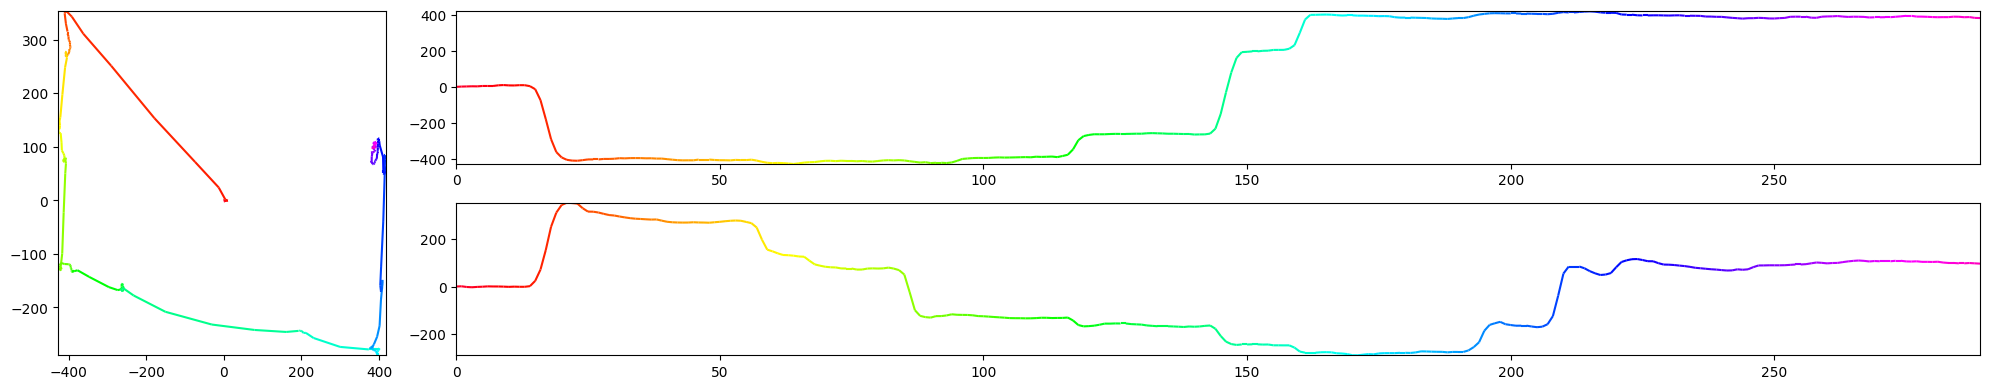

In [28]:
data, config = load_with_config("/home/user/workspace/research/eye-writing/self_data/", "/home/user/workspace/research/eye-writing/load_data_config.csv")
apply_normalize(data)
plot_data2(data[0][0])

정규화 처리

In [10]:
x = match_length(data, 128)
x = np.reshape(x, (-1,x.shape[-2], x.shape[-1]))
print(x.shape)
for i in range(x.shape[0]):
    min_vals = np.min(x[i, :, :], axis=0)
    max_vals = np.max(x[i, :, :], axis=0)
    min_max_diff = [max_vals[j] - min_vals[j] for j in range(x.shape[2])]
    base_channel = np.argmax(min_max_diff)
    if not min_max_diff[base_channel]:
        print(f"{i} index : divide by zero")
        print(f"{min_vals} / {max_vals} / {min_max_diff}")
        continue
    x[i, :, :] = (x[i, :, :] - min_vals[base_channel]) / min_max_diff[base_channel]

(540, 128, 2)


In [13]:
# target_data = x
# save_dir = "/home/user/img"
# for i in range(len(target_data)):
#     plot_data2(target_data[i], f"{save_dir}/{i}.png", "gist_rainbow")

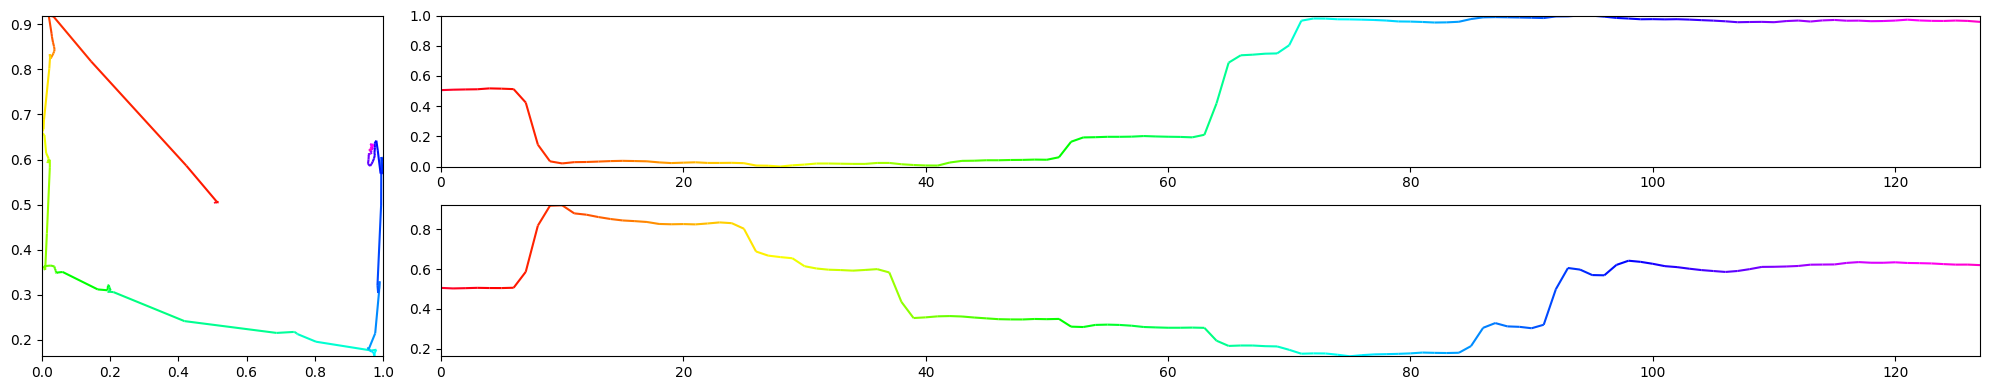

In [11]:
plot_data2(x[0], None)

TIMEGAN

In [7]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [49]:
#Specific to TimeGANs
seq_len=x.shape[1]
n_seq = x.shape[2]
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 64

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [50]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(x, train_steps=5000)
    synth.save('synthesizer_stock.pkl')

Joint networks training: 100%|██████████| 5000/5000 [2:07:29<00:00,  1.53s/it]  


In [51]:
synth_data = synth.sample(len(x))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s]

(576, 128, 2)


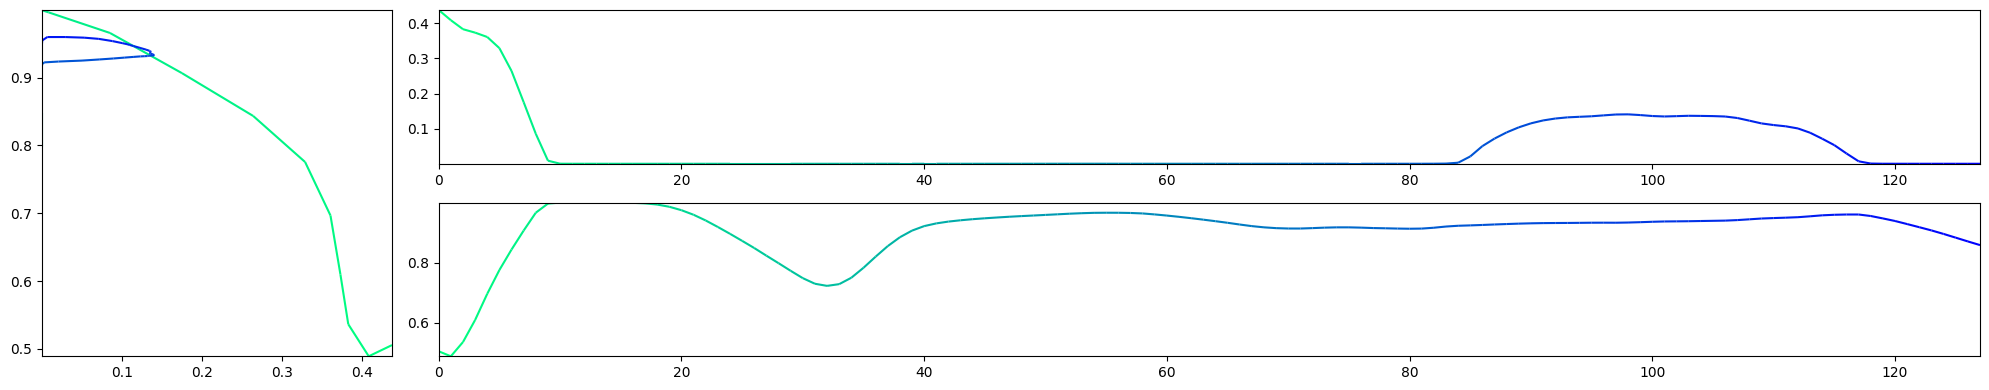

In [52]:
plot_data2(synth_data[0], None)

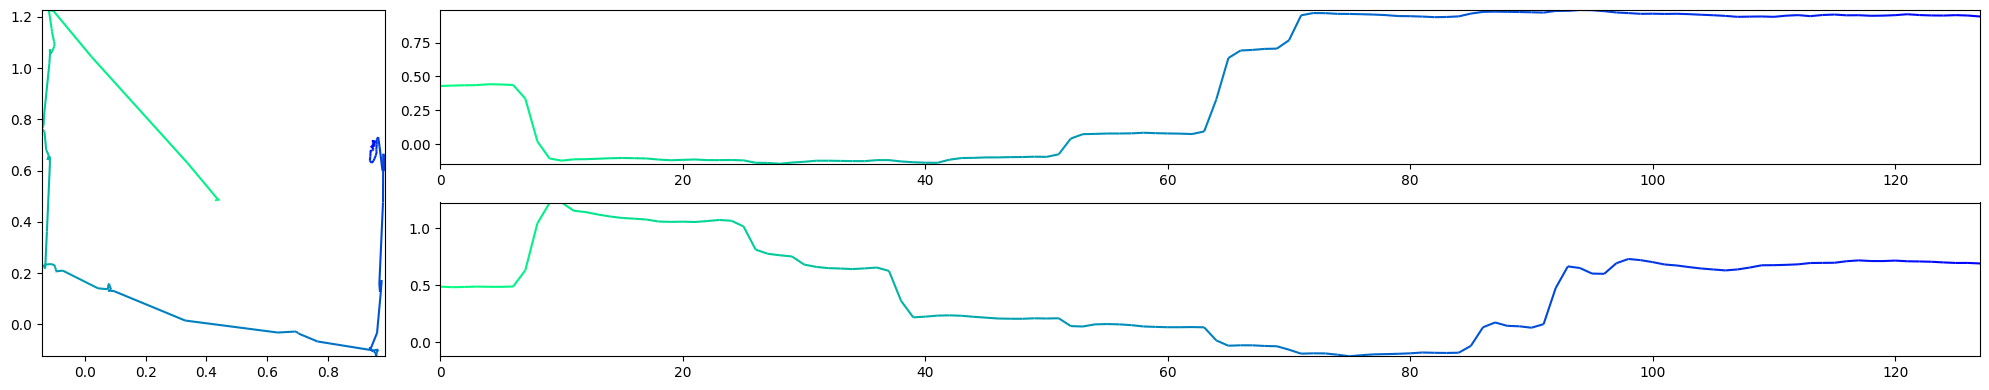

In [53]:
plot_data2(x[0], None)

In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(x))[:sample_size]

real_sample = np.asarray(x)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

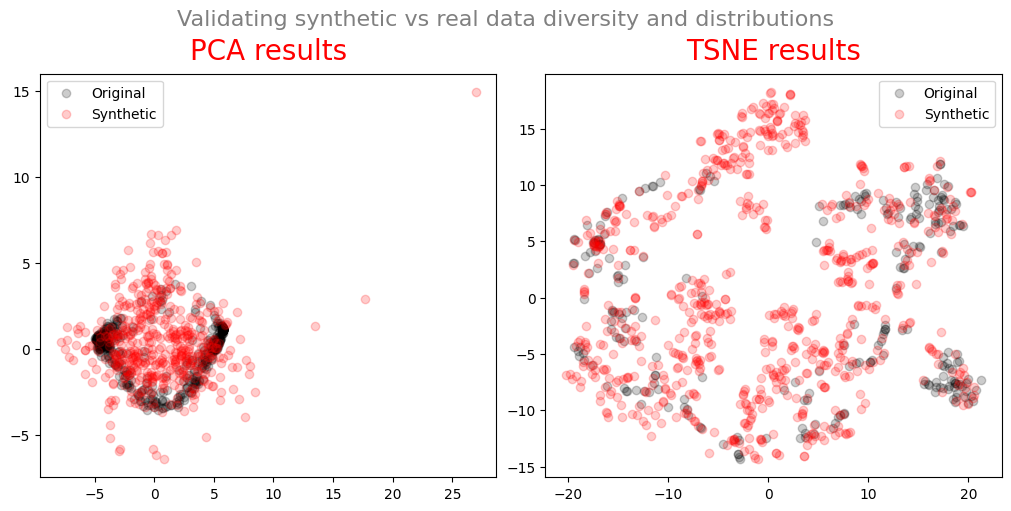

In [55]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(10,5))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')